In [1]:
import keras
from keras.models import load_model , Model
m=load_model('pneumonia.h5')
# make a model to get output before flatten
m.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150, 150, 3)       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 150, 150, 8)       224       
_________________________________________________________________
conv_1 (Conv2D)              (None, 150, 150, 8)       584       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 16)        1168      
_________________________________________________________________
conv_3 (Conv2D)              (None, 50, 50, 16)        2320      
__________

In [2]:
for layers in m.layers:
    print(layers.name)
layer_dict = dict([(layer.name, layer) for layer in m.layers])

input
conv_0
conv_1
pool1
dropout_1
conv_2
conv_3
pool2
dropout_2
conv_4
conv_5
pool3
dropout_3
flat_input
hidden1
hidden2
output


In [3]:
# to install Conx package go to https://github.com/Calysto/conx
# https://github.com/Calysto/conx-notebooks/tree/master/HowToRun#how-to-run-conx
# exercise for all deep learning : https://github.com/Calysto/conx-notebooks
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from skimage.io import imread
### load dataset 

X=np.load('X.npy')
y=np.load('Y.npy')
print(X.shape, y.shape)
np.unique(y, return_counts=True)
y[75],y[32]


(100, 150, 150, 3) (100,)


(0, 1)

In [4]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([m.layers[0].input],
                                  [m.layers[-5].output])
layer_output_pneumonia = get_3rd_layer_output([X[75].reshape(1,150,150,3)])[0]
layer_output_healthy = get_3rd_layer_output([X[32].reshape(1,150,150,3)])[0]
layer_output_pneumonia.shape , layer_output_healthy.shape

((1, 5, 5, 24), (1, 5, 5, 24))

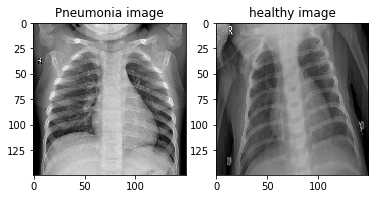

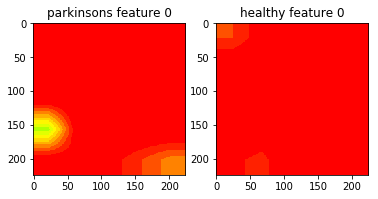

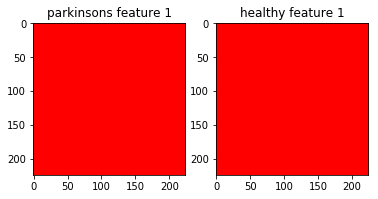

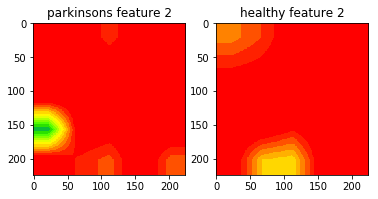

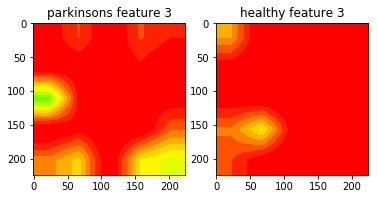

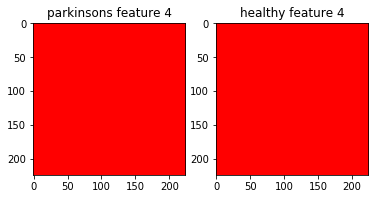

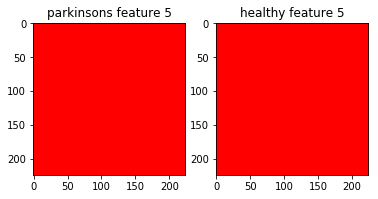

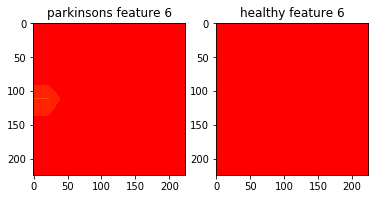

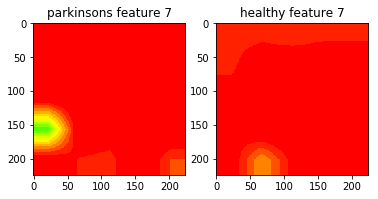

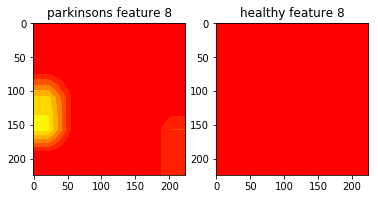

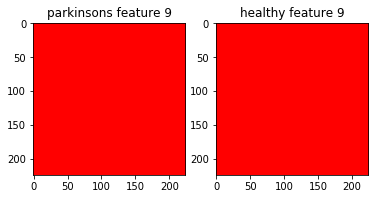

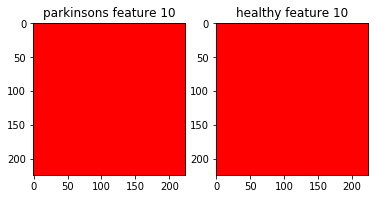

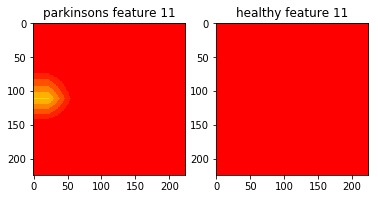

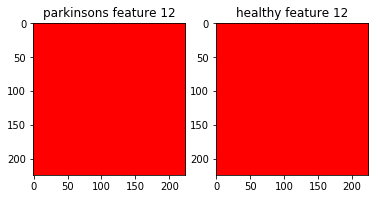

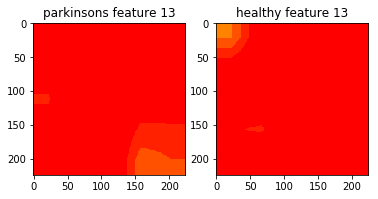

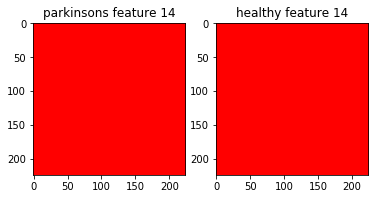

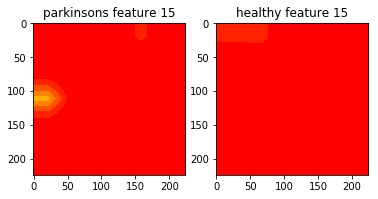

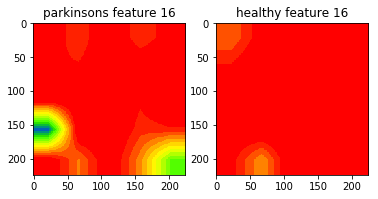

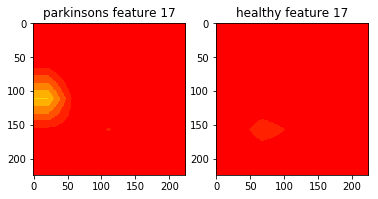

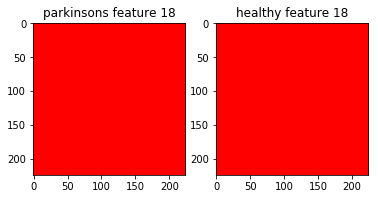

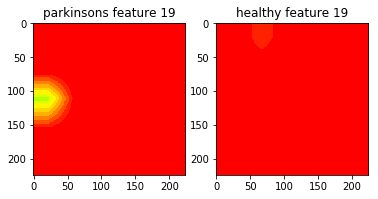

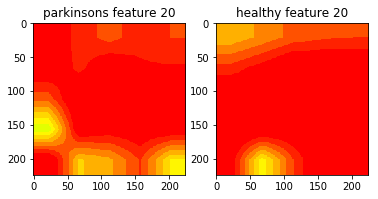

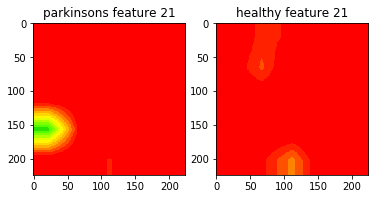

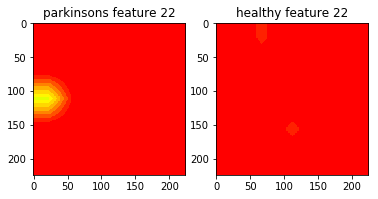

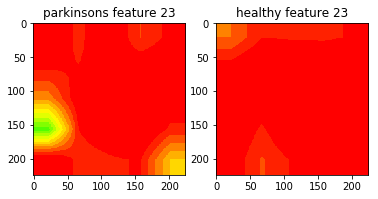

In [10]:
%matplotlib inline
# plot the original two images
import random
import matplotlib.pyplot as plt
import cv2
plt.subplot(1,2,1)
plt.imshow(X[-1],cmap="gray", vmin=0, vmax=255)
plt.title("Pneumonia image")
plt.subplot(1,2,2)
plt.imshow(X[0], cmap="gray", vmin=0, vmax=255)
plt.title("healthy image")
plt.show()
#plot the features for these two image, what the model see
for i in range(24):
    o1=layer_output_pneumonia[0,:,:,i]
    o2=layer_output_healthy[0,:,:,i]
    o1 = cv2.resize(o1,(224,224))
    o2 = cv2.resize(o2,(224,224))

    plt.subplot(1,2,1)
    plt.imshow(o1, cmap='prism', vmin=0, vmax=255)
    plt.title("parkinsons feature {}".format(str(i)))    
    plt.subplot(1,2,2)
    plt.imshow(o2, cmap='prism', vmin=0, vmax=255)
    plt.title("healthy feature {}".format(str(i)))    
    plt.show()

# Visualizing Saliency map = what the model actually sees 

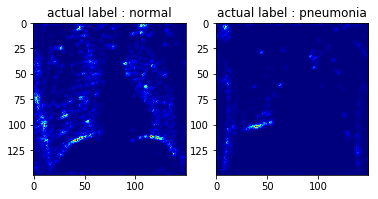

In [26]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(m, 'conv_5')
labels= ['pneumonia' if k==1 else 'normal' for k in [y[75],y[32]]]
f, ax = plt.subplots(1, 2)
for i, img in enumerate([X[75], X[32]]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(m, layer_idx, filter_indices=20, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')
    ax[i].set_title("actual label : "+labels[i])

In [27]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations


# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(m, 'output')

# Swap softmax with linear
m.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(m)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150, 150, 3)       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 150, 150, 8)       224       
_________________________________________________________________
conv_1 (Conv2D)              (None, 150, 150, 8)       584       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 16)        1168      
_________________________________________________________________
conv_3 (Conv2D)              (None, 50, 50, 16)        2320      
__________

# attention map

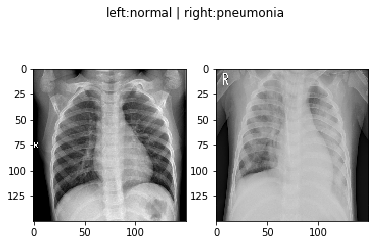

<Figure size 432x288 with 0 Axes>

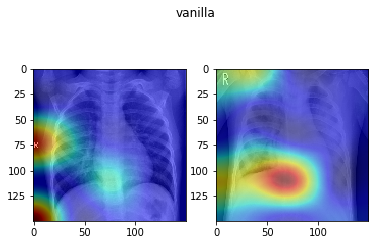

<Figure size 432x288 with 0 Axes>

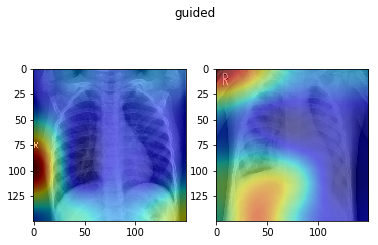

<Figure size 432x288 with 0 Axes>

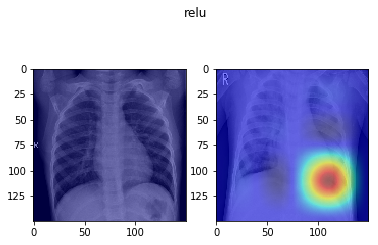

In [37]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam
f, ax = plt.subplots(1, 2)
plt.suptitle("left:normal | right:pneumonia")
ax[0].imshow(X[75])
ax[1].imshow(X[32])


for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([X[75], X[32]]):    
        
        grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

# conv filters visualization

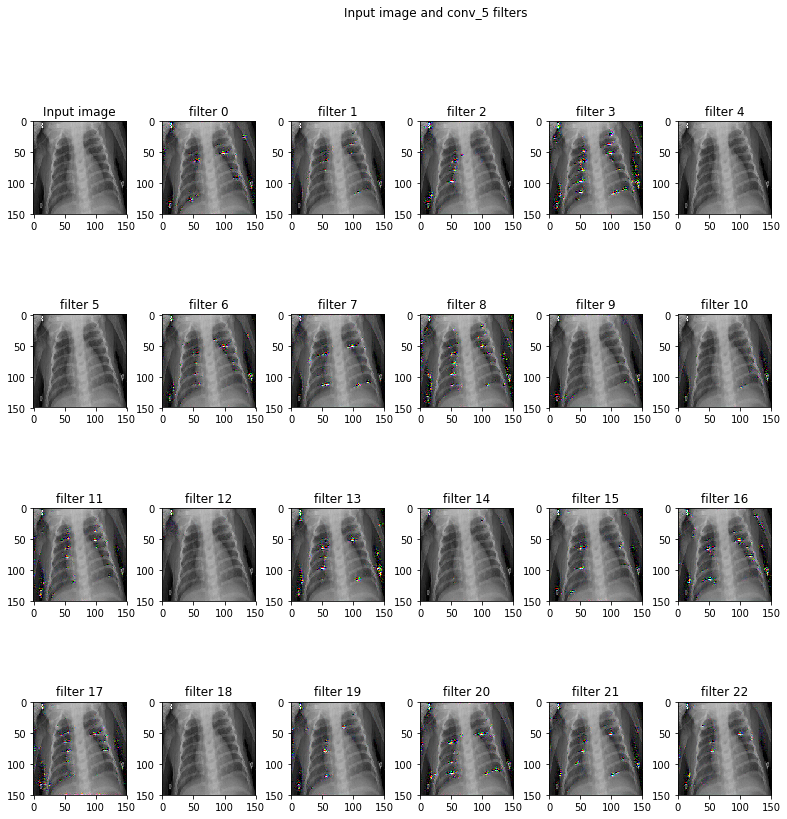

In [35]:
import keras
from keras import backend as K
# util function to convert a tensor into a valid image
def deprocess_image(x):
    x = np.clip(x, 0, 255).astype('uint8')
    return x
def vis_img_in_filter(img = np.array(X[0]).reshape((1, 150, 150, 3)).astype(np.float64), 
                      layer_name = 'conv_5'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, m.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([m.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step
            #print("img_asc.shape",img_asc.shape)

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((150, 150,3)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(deprocess_image(img).reshape((150, 150,3)))
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()